### 고령자 비율이 높은 지역일수록 고령자 교통사고 발생 빈도가 높다.

귀무가설(H0): 고령자 비율은 고령자 교통사고 피해자 비율과 관련이 없다.
<br>
<br>
대립가설(H1): 고령자 비율은 고령자 교통사고 피해자 비율과 관련이 있다.

In [360]:
# 라이브러리 호출 및 plot 설정
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from rapidfuzz import process, fuzz
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import warnings

#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

In [361]:
df_total = pd.read_csv('../../data/preprocessed_data/시도_시군구별_보행자_사고_사고유형_전처리ver.csv')
# df_total
HTML(df_total.head().to_html())

,연도,시군구,법정동코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,도로형태,피해자 상해정도
0,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상
1,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로안,중상
2,2020,서울특별시 종로구 통인동,1111010800,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상
3,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 차도통행중,교차로 - 교차로안,경상
4,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상


In [362]:
df_total.sort_values('법정동코드', inplace=False)

,연도,시군구,법정동코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,도로형태,피해자 상해정도
19379,2022,서울특별시 종로구 청운동,1111010100,경상사고,0,0,1,0,차대사람 - 횡단중,교차로 - 교차로횡단보도내,경상
9620,2021,서울특별시 종로구 궁정동,1111010300,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상
0,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상
1,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로안,중상
9621,2021,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 길가장자리구역통행중,단일로 - 기타,중상
...,...,...,...,...,...,...,...,...,...,...,...
51670,2024,전북특별자치도 부안군 진서면,5280037000,중상사고,0,1,0,0,차대사람 - 횡단중,교차로 - 교차로부근,중상
40504,2023,전라북도 부안군 상서면,5280039000,사망사고,1,0,0,0,차대사람 - 차도통행중,단일로 - 기타,사망
40505,2023,전라북도 부안군 하서면,5280040000,중상사고,0,1,0,0,차대사람 - 기타,단일로 - 기타,중상
29699,2022,전라북도 부안군 줄포면,5280041000,중상사고,0,1,0,0,차대사람 - 차도통행중,단일로 - 지하차도(도로)내,중상


In [363]:
df_elderly_rate = pd.read_csv('../../data/preprocessed_data/시군구_고령자_비율_전처리ver.csv')
# df_elderly_rate
HTML(df_elderly_rate.head().to_html())

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%),시군구명
0,2020,서울특별시 종로구,1111000000,149384,28311,19,서울특별시 종로구
1,2020,서울특별시 중구,1114000000,125240,24174,19.3,서울특별시 중구
2,2020,서울특별시 용산구,1117000000,230040,39779,17.3,서울특별시 용산구
3,2020,서울특별시 성동구,1120000000,293556,45435,15.5,서울특별시 성동구
4,2020,서울특별시 광진구,1121500000,346682,50311,14.5,서울특별시 광진구


In [364]:
#시군구와 시군구명 컬럼이 같음 확인
sum(df_elderly_rate['시군구']!=df_elderly_rate['시군구명'])

0

In [365]:
#시군구명 컬럼 제거
df_elderly_rate.drop('시군구명', axis=1, inplace=True)

In [366]:
df_elderly_rate

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%)
0,2020,서울특별시 종로구,1111000000,149384,28311,19
1,2020,서울특별시 중구,1114000000,125240,24174,19.3
2,2020,서울특별시 용산구,1117000000,230040,39779,17.3
3,2020,서울특별시 성동구,1120000000,293556,45435,15.5
4,2020,서울특별시 광진구,1121500000,346682,50311,14.5
...,...,...,...,...,...,...
1145,2024,전라북도 정읍시,5218000000,102127,32647,32
1146,2024,전라북도 남원시,5219000000,75647,24831,32.8
1147,2024,전라북도 김제시,5221000000,80635,28533,35.4
1148,2024,전라북도 임실군,5275000000,25577,10617,41.5


In [367]:
# 숫자로 변환 불가능한 값들 확인
non_numeric = df_elderly_rate[~df_elderly_rate['고령자 비율 (%)'].str.replace('.', '', regex=False).str.isnumeric()]
print(non_numeric['고령자 비율 (%)'].unique())

['-']


In [368]:
non_numeric

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%)
49,2020,대구광역시 군위군,2772000000,-,-,-
279,2021,대구광역시 군위군,2772000000,-,-,-
509,2022,대구광역시 군위군,2772000000,-,-,-
861,2023,경상북도 군위군,4773000000,-,-,-
1091,2024,경상북도 군위군,4773000000,-,-,-


In [369]:
# 의미 없는 값이기에 '-' 제거
df_elderly_rate = df_elderly_rate.merge(non_numeric, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

In [370]:
#결측치 없음
df_elderly_rate.isnull().sum()

연도            0
시군구           0
법정동코드         0
총 인구          0
고령자 수         0
고령자 비율 (%)    0
dtype: int64

In [371]:
#겹치는 연도별 시군구 없음
(df_elderly_rate[['연도', '시군구']].value_counts() > 1).sum()

0

In [372]:
df_elderly_rate

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%)
0,2020,강원도 강릉시,5115000000,213321,45484,21.3
1,2020,강원도 고성군,5182000000,26757,7945,29.7
2,2020,강원도 동해시,5117000000,90593,18293,20.2
3,2020,강원도 삼척시,5123000000,65243,16572,25.4
4,2020,강원도 속초시,5121000000,82665,15874,19.2
...,...,...,...,...,...,...
1145,2024,충청북도 제천시,4315000000,128569,35347,27.5
1146,2024,충청북도 증평군,4374500000,37171,8044,21.6
1147,2024,충청북도 진천군,4375000000,86537,16767,19.4
1148,2024,충청북도 청주시,4311000000,854537,142688,16.7


In [373]:
df_elderly_rate.reset_index(drop=True, inplace=True)
df_elderly_rate

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%)
0,2020,강원도 강릉시,5115000000,213321,45484,21.3
1,2020,강원도 고성군,5182000000,26757,7945,29.7
2,2020,강원도 동해시,5117000000,90593,18293,20.2
3,2020,강원도 삼척시,5123000000,65243,16572,25.4
4,2020,강원도 속초시,5121000000,82665,15874,19.2
...,...,...,...,...,...,...
1140,2024,충청북도 제천시,4315000000,128569,35347,27.5
1141,2024,충청북도 증평군,4374500000,37171,8044,21.6
1142,2024,충청북도 진천군,4375000000,86537,16767,19.4
1143,2024,충청북도 청주시,4311000000,854537,142688,16.7


In [374]:
def get_victim_stats_by_city_district(df):
    """
    시군구에서 '세종특별자치시 XXX'는 '세종특별자치시'로
    그 외는 앞 2단어(예: '서울특별시 동대문구')로 추출하여
    피해자 수(총합 + 유형별)를 합산한 데이터프레임 반환
    """
    df = df.copy()

    # 시군구 요약 처리
    def normalize_city_district(name):
        if isinstance(name, str) and name.startswith('세종특별자치시'):
            return '세종특별자치시'
        elif isinstance(name, str):
            return ' '.join(name.split()[:2])
        return name

    df['시군구'] = df['시군구'].apply(normalize_city_district)

    # Null 값 0으로 처리
    for col in ['사망자수', '중상자수', '경상자수', '부상신고자수']:
        df[col] = df[col].fillna(0)

    # 피해자 수 총합 계산
    df['피해자수'] = (
        df['사망자수'] +
        df['중상자수'] +
        df['경상자수'] +
        df['부상신고자수']
    )

    # 시군구 기준 그룹화
    summary = df.groupby(['연도', '시군구']).agg({
        '사망자수': 'sum',
        '중상자수': 'sum',
        '경상자수': 'sum',
        '부상신고자수': 'sum',
        '피해자수': 'sum'
    }).reset_index()

    # 피해자 수 기준 정렬
    summary = summary.sort_values(by='피해자수', ascending=False)

    return summary

In [375]:
victim_summary_df = get_victim_stats_by_city_district(df_total)
victim_summary_df.set_index('시군구', inplace=True)
victim_summary_df.reset_index(inplace=True)
victim_summary_df

,시군구,연도,사망자수,중상자수,경상자수,부상신고자수,피해자수
0,경기도 수원시,2023,10,115,117,18,260
1,경기도 부천시,2023,5,104,105,11,225
2,경상남도 창원시,2024,10,122,74,13,219
3,경기도 수원시,2024,11,97,97,9,214
4,경상남도 창원시,2023,15,124,62,13,214
...,...,...,...,...,...,...,...
1173,전북특별자치도 완주군,2023,1,0,0,0,1
1174,강원도 철원군,2021,0,1,0,0,1
1175,강원특별자치도 양구군,2023,0,1,0,0,1
1176,강원도 인제군,2021,0,0,1,0,1


In [376]:
# 지역명 통일
replace_dict = {
    '강원특별자치도': '강원도',
    '전북특별자치도': '전라북도',
}

# 시도명 표준화
def standardize_region_name(region_name):
    for old, new in replace_dict.items():
        if region_name.startswith(old):
            return region_name.replace(old, new, 1)
    return region_name

victim_summary_df['시군구'] = victim_summary_df['시군구'].apply(standardize_region_name)
victim_summary_df

,시군구,연도,사망자수,중상자수,경상자수,부상신고자수,피해자수
0,경기도 수원시,2023,10,115,117,18,260
1,경기도 부천시,2023,5,104,105,11,225
2,경상남도 창원시,2024,10,122,74,13,219
3,경기도 수원시,2024,11,97,97,9,214
4,경상남도 창원시,2023,15,124,62,13,214
...,...,...,...,...,...,...,...
1173,전라북도 완주군,2023,1,0,0,0,1
1174,강원도 철원군,2021,0,1,0,0,1
1175,강원도 양구군,2023,0,1,0,0,1
1176,강원도 인제군,2021,0,0,1,0,1


In [377]:
for year in set(df_elderly_rate['연도'].unique()):
    elderly_regions = set(df_elderly_rate[df_elderly_rate['연도']==year]['시군구'].unique())
    victim_regions = set(victim_summary_df[victim_summary_df['연도']==year]['시군구'].unique())

    only_in_elderly = elderly_regions - victim_regions   # 고령자 데이터에는 있지만 피해자 데이터에는 없는 지역
    only_in_victim = victim_regions - elderly_regions    # 피해자 데이터에는 있지만 고령자 데이터에는 없는 지역

    # 결과 확인
    print(f"{year}년 고령자 데이터에만 있는 시군구:")
    print(sorted(only_in_elderly))
    print(f"\n{year}년 피해자 데이터에만 있는 시군구:")
    print(sorted(only_in_victim))
    print()

2020년 고령자 데이터에만 있는 시군구:
['경상북도 울릉군', '인천광역시 옹진군']

2020년 피해자 데이터에만 있는 시군구:
[]

2021년 고령자 데이터에만 있는 시군구:
['인천광역시 옹진군']

2021년 피해자 데이터에만 있는 시군구:
[]

2022년 고령자 데이터에만 있는 시군구:
[]

2022년 피해자 데이터에만 있는 시군구:
[]

2023년 고령자 데이터에만 있는 시군구:
[]

2023년 피해자 데이터에만 있는 시군구:
['경상북도 군위군']

2024년 고령자 데이터에만 있는 시군구:
[]

2024년 피해자 데이터에만 있는 시군구:
[]



In [378]:
# 일치 결과 저장 리스트
mapping = []

for i, row in df_elderly_rate.iterrows():

    elderly_region = row['시군구']
    year = row['연도']
    victim_of_year_df = victim_summary_df[victim_summary_df['연도'] == year]

    best_match, score, _ = process.extractOne(
        elderly_region,
        victim_of_year_df['시군구'],
        scorer=fuzz.ratio
    )

    if score >= 80 :  # 유사도 기준
        victim_row = victim_of_year_df[victim_of_year_df['시군구'] == best_match].iloc[0]
        merged_row = {
            '연도':  row['연도'],
            '시군구': elderly_region,
            '고령자 비율 (%)': row['고령자 비율 (%)'],
            '총 인구': row['총 인구'],
            '고령자 수': row['고령자 수'],
            '사망자수': victim_row['사망자수'],
            '중상자수': victim_row['중상자수'],
            '경상자수': victim_row['경상자수'],
            '부상신고자수': victim_row['부상신고자수'],
            '피해자수': victim_row['피해자수']
        }
        mapping.append(merged_row)

# 매핑된 데이터프레임 생성
df_merged = pd.DataFrame(mapping)
# df_merged
HTML(df_merged.head(5).to_html(index=False))

연도,시군구,고령자 비율 (%),총 인구,고령자 수,사망자수,중상자수,경상자수,부상신고자수,피해자수
2020,강원도 강릉시,21.3,213321,45484,1,24,17,1,43
2020,강원도 고성군,29.7,26757,7945,0,2,0,2,4
2020,강원도 동해시,20.2,90593,18293,1,8,8,0,17
2020,강원도 삼척시,25.4,65243,16572,1,14,6,0,21
2020,강원도 속초시,19.2,82665,15874,0,19,8,0,27


In [379]:
df_merged

,연도,시군구,고령자 비율 (%),총 인구,고령자 수,사망자수,중상자수,경상자수,부상신고자수,피해자수
0,2020,강원도 강릉시,21.3,213321,45484,1,24,17,1,43
1,2020,강원도 고성군,29.7,26757,7945,0,2,0,2,4
2,2020,강원도 동해시,20.2,90593,18293,1,8,8,0,17
3,2020,강원도 삼척시,25.4,65243,16572,1,14,6,0,21
4,2020,강원도 속초시,19.2,82665,15874,0,19,8,0,27
...,...,...,...,...,...,...,...,...,...,...
1138,2024,충청북도 제천시,27.5,128569,35347,3,26,25,4,58
1139,2024,충청북도 증평군,21.6,37171,8044,2,5,4,0,11
1140,2024,충청북도 진천군,19.4,86537,16767,1,13,6,0,20
1141,2024,충청북도 청주시,16.7,854537,142688,7,84,58,8,157


In [380]:
df_merged[df_merged['시군구'].str.split().str[1] == '창원시']

,연도,시군구,고령자 비율 (%),총 인구,고령자 수,사망자수,중상자수,경상자수,부상신고자수,피해자수
61,2020,경상남도 창원시,14.6,1036738,150905,5,109,56,2,172
289,2021,경상남도 창원시,15.5,1032741,160521,17,100,60,4,181
517,2022,경상남도 창원시,16.7,1021487,170273,14,107,65,10,196
746,2023,경상남도 창원시,17.9,1009038,180319,15,124,62,13,214
975,2024,경상남도 창원시,19.2,999858,192030,10,122,74,13,219


In [381]:
df_total_acc = pd.read_csv('../../data/preprocessed_data/시군구별_전체_보행자_교통사고_전처리ver.csv', header=[0], index_col=None)

In [382]:
df_total_acc

,연도,시도,시군구,사고[건],사망[명],부상[명],중상자[명],경상자[명],부상신고자[명]
0,2020,서울,종로구,226,2,234,85,127,22
1,2020,서울,중구,246,1,254,113,125,16
2,2020,서울,용산구,159,6,158,59,95,4
3,2020,서울,성동구,244,5,248,78,151,19
4,2020,서울,동대문구,331,5,336,141,178,17
...,...,...,...,...,...,...,...,...,...
1145,2024,경남,거창군,36,1,38,23,14,1
1146,2024,경남,합천군,24,0,28,12,10,6
1147,2024,경남,창원시(통합),654,18,660,269,305,86
1148,2024,제주,제주시,610,15,609,192,373,44


In [383]:
# 숫자로 변환 불가능한 값들 확인
numeric_check_df = df_total_acc.drop(columns=['시도', '시군구'])

# 숫자가 아닌 값을 포함한 행 마스크
non_numeric_mask = ~numeric_check_df.applymap(lambda x: pd.api.types.is_number(x)).all(axis=1)

# 원래 df에서 해당 행들 추출
result = df_total_acc[non_numeric_mask]

In [384]:
result

,연도,시도,시군구,사고[건],사망[명],부상[명],중상자[명],경상자[명],부상신고자[명]
0,2020,서울,종로구,226,2,234,85,127,22
1,2020,서울,중구,246,1,254,113,125,16
2,2020,서울,용산구,159,6,158,59,95,4
3,2020,서울,성동구,244,5,248,78,151,19
4,2020,서울,동대문구,331,5,336,141,178,17
...,...,...,...,...,...,...,...,...,...
1145,2024,경남,거창군,36,1,38,23,14,1
1146,2024,경남,합천군,24,0,28,12,10,6
1147,2024,경남,창원시(통합),654,18,660,269,305,86
1148,2024,제주,제주시,610,15,609,192,373,44


In [385]:
type(df_total_acc.iloc[0, 4])
#df_total_acc.iloc[0, 3]

str

In [386]:
df_total_acc = df_total_acc.apply(lambda col: pd.to_numeric(col, errors='coerce').astype('Int64') if col.name not in ['시도', '시군구'] else col)


In [387]:
# 숫자로 변환 불가능한 값들 확인
numeric_check_df = df_total_acc.drop(columns=['시도', '시군구'])

# 숫자가 아닌 값을 포함한 행 마스크
non_numeric_mask = ~numeric_check_df.applymap(lambda x: pd.api.types.is_number(x)).all(axis=1)

# 원래 df에서 해당 행들 추출
result = df_total_acc[non_numeric_mask]
result

,연도,시도,시군구,사고[건],사망[명],부상[명],중상자[명],경상자[명],부상신고자[명]


In [388]:
type(df_total_acc.iloc[0, 4])

numpy.int64

In [389]:
df_total_acc

,연도,시도,시군구,사고[건],사망[명],부상[명],중상자[명],경상자[명],부상신고자[명]
0,2020,서울,종로구,226,2,234,85,127,22
1,2020,서울,중구,246,1,254,113,125,16
2,2020,서울,용산구,159,6,158,59,95,4
3,2020,서울,성동구,244,5,248,78,151,19
4,2020,서울,동대문구,331,5,336,141,178,17
...,...,...,...,...,...,...,...,...,...
1145,2024,경남,거창군,36,1,38,23,14,1
1146,2024,경남,합천군,24,0,28,12,10,6
1147,2024,경남,창원시(통합),654,18,660,269,305,86
1148,2024,제주,제주시,610,15,609,192,373,44


<hr>
폐기한 방법 - 자동 매칭

In [390]:
# regions = sorted(set(victim_summary_df['시군구'].str.split().str[0]))


# for i, row in df_total_acc.iterrows():

#     raw_region = row['시도']

#     best_match, score, _ = process.extractOne(
#         raw_region,
#         regions,
#         scorer=fuzz.partial_ratio
#     )

#     if score >= 60 :  # 유사도 기준
#         df_total_acc.at[i, '시도'] = best_match

In [391]:
#len(regions)

In [392]:
#len(set(df_total_acc['시도']))

In [393]:
# print(set(df_total_acc['시도']) - set(regions))
# print(set(regions) - set(df_total_acc['시도']))

<hr>

In [394]:
eld_reg = set(victim_summary_df['시군구'].str.split().str[0])
all_reg = set(df_total_acc['시도'])

print('노인 보행자 데이터의 시도 값')
print(sorted(eld_reg))
print('\n전체 보행자 데이터의 시도 값')
print(sorted(all_reg))
print('\n\n겹치지 않는 값')
print('노인보행자')
print(eld_reg - all_reg)
print('\n전체 보행자')
print(all_reg - eld_reg)

노인 보행자 데이터의 시도 값
['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']

전체 보행자 데이터의 시도 값
['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


겹치지 않는 값
노인보행자
{'대구광역시', '울산광역시', '세종특별자치시', '강원도', '경상북도', '충청북도', '광주광역시', '서울특별시', '경기도', '전라남도', '경상남도', '대전광역시', '부산광역시', '충청남도', '전라북도', '제주특별자치도', '인천광역시'}

전체 보행자
{'강원', '서울', '충남', '울산', '광주', '부산', '세종', '경북', '인천', '제주', '충북', '전북', '경기', '경남', '대구', '대전', '전남'}


In [395]:
df_total_acc['시도'] = df_total_acc['시도'].replace({
    '강원' : '강원도',
    '서울' : '서울특별시',
    '충남' : '충청남도',
    '울산' : '울산광역시',
    '광주' : '광주광역시',
    '부산' : '부산광역시',
    '세종' : '세종특별자치시',
    '경북' : '경상북도',
    '인천' : '인천광역시',
    '제주' : '제주특별자치도',
    '충북' : '충청북도',
    '전북' : '전라북도',
    '경기' : '경기도',
    '경남' : '경상남도',
    '대구' : '대구광역시',
    '대전' : '대전광역시',
    '전남' : '전라남도'
})

In [396]:
eld_reg = set(victim_summary_df['시군구'].str.split().str[0])
all_reg = set(df_total_acc['시도'])

print('노인 보행자 데이터의 시도 값')
print(sorted(eld_reg))
print('\n전체 보행자 데이터의 시도 값')
print(sorted(all_reg))
print('\n\n겹치지 않는 값')
print('노인보행자')
print(eld_reg - all_reg)
print('\n전체 보행자')
print(all_reg - eld_reg)

노인 보행자 데이터의 시도 값
['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']

전체 보행자 데이터의 시도 값
['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']


겹치지 않는 값
노인보행자
set()

전체 보행자
set()


In [397]:
df_total_acc

,연도,시도,시군구,사고[건],사망[명],부상[명],중상자[명],경상자[명],부상신고자[명]
0,2020,서울특별시,종로구,226,2,234,85,127,22
1,2020,서울특별시,중구,246,1,254,113,125,16
2,2020,서울특별시,용산구,159,6,158,59,95,4
3,2020,서울특별시,성동구,244,5,248,78,151,19
4,2020,서울특별시,동대문구,331,5,336,141,178,17
...,...,...,...,...,...,...,...,...,...
1145,2024,경상남도,거창군,36,1,38,23,14,1
1146,2024,경상남도,합천군,24,0,28,12,10,6
1147,2024,경상남도,창원시(통합),654,18,660,269,305,86
1148,2024,제주특별자치도,제주시,610,15,609,192,373,44


In [398]:
df_total_acc['시군구'] = df_total_acc['시도'].str.replace(' ', '') + ' ' + df_total_acc['시군구'].str.replace(' ', '')

In [399]:
df_total_acc.drop('시도', axis=1, inplace=True)

In [400]:
df_total_acc['전체 교통사고 피해자[명]'] = df_total_acc['사망[명]'] + df_total_acc['부상[명]']
df_total_acc.drop(['사고[건]', '사망[명]', '부상[명]', '중상자[명]', '경상자[명]', '부상신고자[명]'], axis=1, inplace=True)

In [401]:
df_total_acc['전체 교통사고 피해자[명]']

0       236
1       255
2       164
3       253
4       341
       ... 
1145     39
1146     28
1147    678
1148    624
1149    202
Name: 전체 교통사고 피해자[명], Length: 1150, dtype: Int64

In [402]:
df_total_acc

,연도,시군구,전체 교통사고 피해자[명]
0,2020,서울특별시 종로구,236
1,2020,서울특별시 중구,255
2,2020,서울특별시 용산구,164
3,2020,서울특별시 성동구,253
4,2020,서울특별시 동대문구,341
...,...,...,...
1145,2024,경상남도 거창군,39
1146,2024,경상남도 합천군,28
1147,2024,경상남도 창원시(통합),678
1148,2024,제주특별자치도 제주시,624


In [403]:
for year in set(df_merged['연도'].unique()):
    merged_regions = set(df_merged[df_merged['연도']==year]['시군구'].unique())
    all_victim_regions = set(df_total_acc[df_total_acc['연도']==year]['시군구'].unique())

    only_in_merged = merged_regions - all_victim_regions   # 고령자 데이터에는 있지만 피해자 데이터에는 없는 지역
    only_in_all_victim = all_victim_regions - merged_regions    # 피해자 데이터에는 있지만 고령자 데이터에는 없는 지역

    # 결과 확인
    print(f"{year}년 합성 데이터에만 있는 시군구:")
    print(sorted(only_in_merged))
    print(f"\n{year}년 총 사고 피해자 데이터에만 있는 시군구:")
    print(sorted(only_in_all_victim))
    print()

2020년 합성 데이터에만 있는 시군구:
['경상남도 창원시', '부산광역시 부산진구', '세종특별자치시']

2020년 총 사고 피해자 데이터에만 있는 시군구:
['경상남도 창원시(통합)', '대구광역시 군위군', '부산광역시 진구', '세종특별자치시 세종시', '인천광역시 옹진군']

2021년 합성 데이터에만 있는 시군구:
['경상남도 창원시', '부산광역시 부산진구', '세종특별자치시']

2021년 총 사고 피해자 데이터에만 있는 시군구:
['경상남도 창원시(통합)', '대구광역시 군위군', '부산광역시 진구', '세종특별자치시 세종시', '인천광역시 옹진군']

2022년 합성 데이터에만 있는 시군구:
['경상남도 창원시', '부산광역시 부산진구', '세종특별자치시']

2022년 총 사고 피해자 데이터에만 있는 시군구:
['경상남도 창원시(통합)', '대구광역시 군위군', '부산광역시 진구', '세종특별자치시 세종시']

2023년 합성 데이터에만 있는 시군구:
['경상남도 창원시', '부산광역시 부산진구', '세종특별자치시']

2023년 총 사고 피해자 데이터에만 있는 시군구:
['경상남도 창원시(통합)', '경상북도 군위군', '부산광역시 진구', '세종특별자치시 세종시']

2024년 합성 데이터에만 있는 시군구:
['경상남도 창원시', '부산광역시 부산진구', '세종특별자치시']

2024년 총 사고 피해자 데이터에만 있는 시군구:
['경상남도 창원시(통합)', '경상북도 군위군', '부산광역시 진구', '세종특별자치시 세종시']



In [404]:
df_total_acc.loc[df_total_acc['시군구'] == '경상남도 창원시(통합)', '시군구'] = '경상남도 창원시'
df_total_acc.loc[df_total_acc['시군구'] == '세종특별자치시 세종시', '시군구'] = '세종특별자치시'
df_total_acc.loc[df_total_acc['시군구'] == '부산광역시 진구', '시군구'] = '부산광역시 부산진구'

In [405]:
for year in set(df_merged['연도'].unique()):
    merged_regions = set(df_merged[df_merged['연도']==year]['시군구'].unique())
    all_victim_regions = set(df_total_acc[df_total_acc['연도']==year]['시군구'].unique())

    only_in_merged = merged_regions - all_victim_regions   # 고령자 데이터에는 있지만 피해자 데이터에는 없는 지역
    only_in_all_victim = all_victim_regions - merged_regions    # 피해자 데이터에는 있지만 고령자 데이터에는 없는 지역

    # 결과 확인
    print(f"{year}년 합성 데이터에만 있는 시군구:")
    print(sorted(only_in_merged))
    print(f"\n{year}년 총 사고 피해자 데이터에만 있는 시군구:")
    print(sorted(only_in_all_victim))
    print()

2020년 합성 데이터에만 있는 시군구:
[]

2020년 총 사고 피해자 데이터에만 있는 시군구:
['대구광역시 군위군', '인천광역시 옹진군']

2021년 합성 데이터에만 있는 시군구:
[]

2021년 총 사고 피해자 데이터에만 있는 시군구:
['대구광역시 군위군', '인천광역시 옹진군']

2022년 합성 데이터에만 있는 시군구:
[]

2022년 총 사고 피해자 데이터에만 있는 시군구:
['대구광역시 군위군']

2023년 합성 데이터에만 있는 시군구:
[]

2023년 총 사고 피해자 데이터에만 있는 시군구:
['경상북도 군위군']

2024년 합성 데이터에만 있는 시군구:
[]

2024년 총 사고 피해자 데이터에만 있는 시군구:
['경상북도 군위군']



In [406]:
df_raw_result = df_merged.merge(
    df_total_acc[['연도', '시군구', '전체 교통사고 피해자[명]']],
    on = ['연도', '시군구'],
    how='left'
)

In [407]:
df_raw_result

,연도,시군구,고령자 비율 (%),총 인구,고령자 수,사망자수,중상자수,경상자수,부상신고자수,피해자수,전체 교통사고 피해자[명]
0,2020,강원도 강릉시,21.3,213321,45484,1,24,17,1,43,177
1,2020,강원도 고성군,29.7,26757,7945,0,2,0,2,4,23
2,2020,강원도 동해시,20.2,90593,18293,1,8,8,0,17,75
3,2020,강원도 삼척시,25.4,65243,16572,1,14,6,0,21,47
4,2020,강원도 속초시,19.2,82665,15874,0,19,8,0,27,82
...,...,...,...,...,...,...,...,...,...,...,...
1138,2024,충청북도 제천시,27.5,128569,35347,3,26,25,4,58,141
1139,2024,충청북도 증평군,21.6,37171,8044,2,5,4,0,11,27
1140,2024,충청북도 진천군,19.4,86537,16767,1,13,6,0,20,64
1141,2024,충청북도 청주시,16.7,854537,142688,7,84,58,8,157,580


In [408]:
df_raw_result.drop(['총 인구', '고령자 수', '사망자수', '중상자수', '경상자수', '부상신고자수'], axis=1, inplace=True)

In [409]:
df_raw_result

,연도,시군구,고령자 비율 (%),피해자수,전체 교통사고 피해자[명]
0,2020,강원도 강릉시,21.3,43,177
1,2020,강원도 고성군,29.7,4,23
2,2020,강원도 동해시,20.2,17,75
3,2020,강원도 삼척시,25.4,21,47
4,2020,강원도 속초시,19.2,27,82
...,...,...,...,...,...
1138,2024,충청북도 제천시,27.5,58,141
1139,2024,충청북도 증평군,21.6,11,27
1140,2024,충청북도 진천군,19.4,20,64
1141,2024,충청북도 청주시,16.7,157,580


In [410]:
df_raw_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'] = (df_raw_result['피해자수'] / df_raw_result['전체 교통사고 피해자[명]'] * 100).round(1)

In [ ]:
df_result = df_raw_result.drop(['피해자수', '전체 교통사고 피해자[명]'], axis=1)

In [413]:
df_result

,연도,시군구,고령자 비율 (%),전체 보행자 교통사고 피해자 중 노인 비율 (%)
0,2020,강원도 강릉시,21.3,24.3
1,2020,강원도 고성군,29.7,17.4
2,2020,강원도 동해시,20.2,22.7
3,2020,강원도 삼척시,25.4,44.7
4,2020,강원도 속초시,19.2,32.9
...,...,...,...,...
1138,2024,충청북도 제천시,27.5,41.1
1139,2024,충청북도 증평군,21.6,40.7
1140,2024,충청북도 진천군,19.4,31.2
1141,2024,충청북도 청주시,16.7,27.1


In [416]:
type(df_result.iloc[0, 2])

str

In [417]:
df_result['고령자 비율 (%)'] = pd.to_numeric(df_result['고령자 비율 (%)'], errors='coerce')

In [418]:
type(df_result.iloc[0, 2])

numpy.float64

In [419]:
df_result.isna().sum()

연도                             0
시군구                            0
고령자 비율 (%)                     0
전체 보행자 교통사고 피해자 중 노인 비율 (%)    0
dtype: int64

In [420]:
df_result

,연도,시군구,고령자 비율 (%),전체 보행자 교통사고 피해자 중 노인 비율 (%)
0,2020,강원도 강릉시,21.3,24.3
1,2020,강원도 고성군,29.7,17.4
2,2020,강원도 동해시,20.2,22.7
3,2020,강원도 삼척시,25.4,44.7
4,2020,강원도 속초시,19.2,32.9
...,...,...,...,...
1138,2024,충청북도 제천시,27.5,41.1
1139,2024,충청북도 증평군,21.6,40.7
1140,2024,충청북도 진천군,19.4,31.2
1141,2024,충청북도 청주시,16.7,27.1


In [430]:
df_result[df_result['고령자 비율 (%)'] > 100]

,연도,시군구,고령자 비율 (%),전체 보행자 교통사고 피해자 중 노인 비율 (%)


In [422]:
df_result[df_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'] > 100]

,연도,시군구,고령자 비율 (%),전체 보행자 교통사고 피해자 중 노인 비율 (%)
83,2020,경상북도 울릉군,26.3,225.0


In [433]:
df_raw_result[df_raw_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'] > 100]

,연도,시군구,고령자 비율 (%),피해자수,전체 교통사고 피해자[명],전체 보행자 교통사고 피해자 중 노인 비율 (%)
83,2020,경상북도 울릉군,26.3,9,4,225.0


In [434]:
#위의 이상치는 새 데이터가 존재하지 않고, 표본은 충분히 많다고 판단되어 삭제처리함
df_result = df_result.drop(83).reset_index(drop=True)

In [436]:
df_result[df_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'] > 100]

,연도,시군구,고령자 비율 (%),전체 보행자 교통사고 피해자 중 노인 비율 (%)


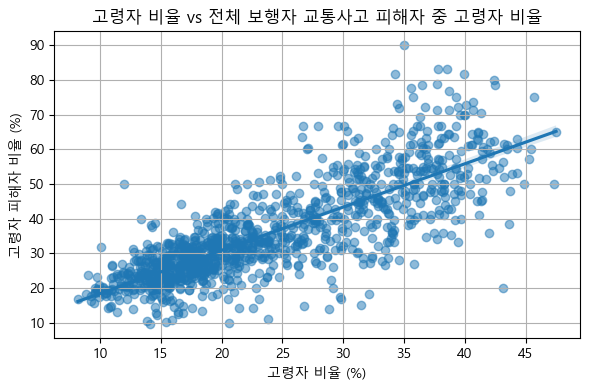

In [437]:
# 고령자 비율 대비 고령자 피해자 비율 확인
plt.figure(figsize=(6, 4))
sns.regplot(data=df_result, x='고령자 비율 (%)', y='전체 보행자 교통사고 피해자 중 노인 비율 (%)', scatter_kws={'alpha':0.5})
plt.title("고령자 비율 vs 전체 보행자 교통사고 피해자 중 고령자 비율")
plt.xlabel("고령자 비율 (%)")
plt.ylabel("고령자 피해자 비율 (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# save_path = '../../outputs/가설_2/고령자_비율_대비_고령자_피해자_수.png'
# plt.savefig(save_path)

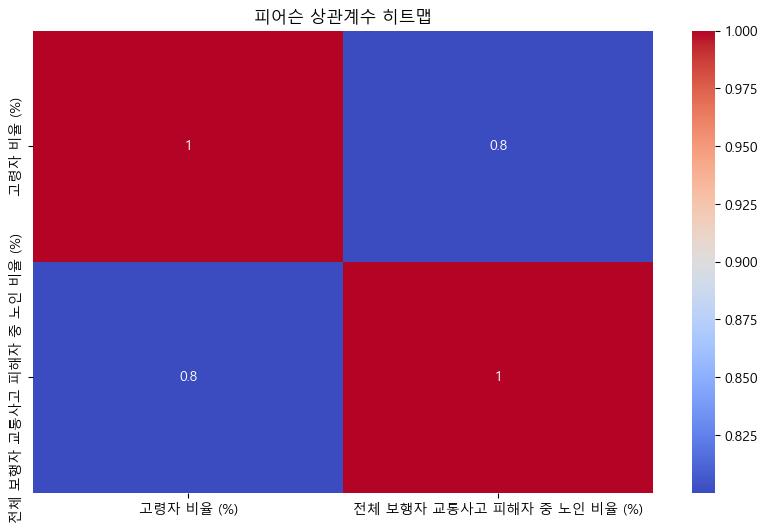

In [440]:
# 피어슨 상관 계수 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df_result[['고령자 비율 (%)', '전체 보행자 교통사고 피해자 중 노인 비율 (%)']].corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('피어슨 상관계수 히트맵')
plt.show()

# save_path = '../../outputs/가설_2/피어슨_상관계수_히트맵.png'
# plt.savefig(save_path)

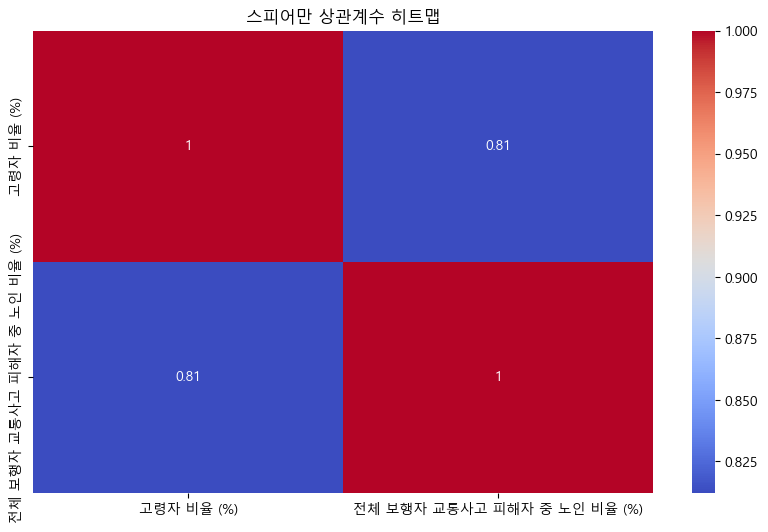

In [441]:
# 스피어만 상관 계수 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df_result[['고령자 비율 (%)', '전체 보행자 교통사고 피해자 중 노인 비율 (%)']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('스피어만 상관계수 히트맵')
plt.show()

# save_path = '../../outputs/가설_2/스피어만_상관계수_히트맵.png'
# plt.savefig(save_path)

In [ ]:
corr, p = pearsonr(df_result['고령자 비율 (%)'], df_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'])
print(f'피어슨 상관계수: {corr:.3f}, p-value: {p:.30f}')

# =================================================
# 양의 상관관계. 고령자 비율이 높을수록 피해자 비율은 증가
# p-value < 0.05이므로, 통계적으로 유의
# =================================================

피어슨 상관계수: 0.800, p-value: 0.000000000000000000000000000000


In [ ]:
corr, p = spearmanr(df_result['고령자 비율 (%)'], df_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)'])
print(f'스피어만 상관계수: {corr:.3f}, p-value: {p:.30f}')

# =================================================
# 양의 상관관계. 고령자 비율이 높을수록 피해자 비율 증가
# p-value < 0.05이므로, 통계적으로 유의
# 귀무가설 기각
# =================================================

스피어만 상관계수: 0.812, p-value: 0.000000000000000000000000000000


In [ ]:
X = df_result['고령자 비율 (%)']
y = df_result['전체 보행자 교통사고 피해자 중 노인 비율 (%)']
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
print(model.summary())

# ======================================================================================================================
# 고령자 비율이 1% 증가할 때, 피해자 비율은 평균적으로 약 1.25% 증가
# p-value는 0.000이므로, 회귀계수가 유의미
# 귀무가설 기각
# 결정계수(R²)=0.640 -> 고령자 비율만으로 고령자 피해자 수의 약 64%를 설명 가능. 나머지는 고령자 절대 수, 차량 수, 인구 밀도 등에 의해 설명 가능.
# ======================================================================================================================

                                 OLS Regression Results                                
Dep. Variable:     전체 보행자 교통사고 피해자 중 노인 비율 (%)   R-squared:                       0.640
Model:                                     OLS   Adj. R-squared:                  0.640
Method:                          Least Squares   F-statistic:                     2027.
Date:                         Fri, 06 Jun 2025   Prob (F-statistic):          3.39e-255
Time:                                 00:57:28   Log-Likelihood:                -4054.6
No. Observations:                         1142   AIC:                             8113.
Df Residuals:                             1140   BIC:                             8123.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------